<a href="https://colab.research.google.com/github/segnig/Financial-Inclusion-in-Africa/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
FILE_PATH = "/content/drive/MyDrive/Data Science/financial-inclusion-in-africa/"

TRAIN_PATH = "Train.csv"
TEST_PATH = "Test.csv"

VARIABLE_DEFINITIONS_PATH = "VariableDefinitions.csv"
SAMPLE_SUBMISSION_PATH = "SampleSubmission.csv"


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# random under/over sampling library
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



# ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Train Dataset


In [4]:
train = pd.read_csv(FILE_PATH + TRAIN_PATH)
train.head()

country  year    uniqueid bank_account location_type cellphone_access  \
0   Kenya  2018  uniqueid_1          Yes         Rural              Yes   
1   Kenya  2018  uniqueid_2           No         Rural               No   
2   Kenya  2018  uniqueid_3          Yes         Urban              Yes   
3   Kenya  2018  uniqueid_4           No         Rural              Yes   
4   Kenya  2018  uniqueid_5           No         Urban               No   

   household_size  age_of_respondent gender_of_respondent  \
0               3                 24               Female   
1               5                 70               Female   
2               5                 26                 Male   
3               5                 34               Female   
4               8                 26                 Male   

  relationship_with_head           marital_status  \
0                 Spouse  Married/Living together   
1      Head of Household                  Widowed   
2         Other relative     Single/Never Married   
3      Head of Household  Married/Living together   
4                  Child     Single/Never Married   

                   education_level                   job_type  
0              Secondary education              Self employed  
1              No formal education       Government Dependent  
2  Vocational/Specialised training              Self employed  
3                Primary education  Formally employed Private  
4                Primary education        Informally employed

## missing values

In [7]:
# missing values checking
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [9]:
# feature name definition

variable_definitions = pd.read_csv(FILE_PATH + VARIABLE_DEFINITIONS_PATH)
variable_definitions

Variable Definitions                                         Unnamed: 1
0                  country                         Country interviewee is in.
1                     year                           Year survey was done in.
2                 uniqueid             Unique identifier for each interviewee
3            location_type                     Type of location: Rural, Urban
4         cellphone_access  If interviewee has access to a cellphone: Yes, No
5           household_size               Number of people living in one house
6        age_of_respondent                         The age of the interviewee
7     gender_of_respondent                Gender of interviewee: Male, Female
8   relationship_with_head  The interviewee’s relationship with the head o...
9           marital_status  The martial status of the interviewee: Married...
10         education_level  Highest level of education: No formal educatio...
11                job_type  Type of job interviewee has: Farming and Fishi...

# data imbalance

In [11]:
train['bank_account'].value_counts()

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

## Two cardinality features

In [13]:
features_cardinality = train.nunique().to_frame('cardinality')
features_cardinality

cardinality
country                           4
year                              3
uniqueid                       8735
bank_account                      2
location_type                     2
cellphone_access                  2
household_size                   20
age_of_respondent                85
gender_of_respondent              2
relationship_with_head            6
marital_status                    5
education_level                   6
job_type                         10

In [34]:
# two caridinalities features
low_cardinality_features = features_cardinality[features_cardinality['cardinality'] < 11].index

In [35]:
train[low_cardinality_features].head()

country  year bank_account location_type cellphone_access  \
0   Kenya  2018          Yes         Rural              Yes   
1   Kenya  2018           No         Rural               No   
2   Kenya  2018          Yes         Urban              Yes   
3   Kenya  2018           No         Rural              Yes   
4   Kenya  2018           No         Urban               No   

  gender_of_respondent relationship_with_head           marital_status  \
0               Female                 Spouse  Married/Living together   
1               Female      Head of Household                  Widowed   
2                 Male         Other relative     Single/Never Married   
3               Female      Head of Household  Married/Living together   
4                 Male                  Child     Single/Never Married   

                   education_level                   job_type  
0              Secondary education              Self employed  
1              No formal education       Government Dependent  
2  Vocational/Specialised training              Self employed  
3                Primary education  Formally employed Private  
4                Primary education        Informally employed

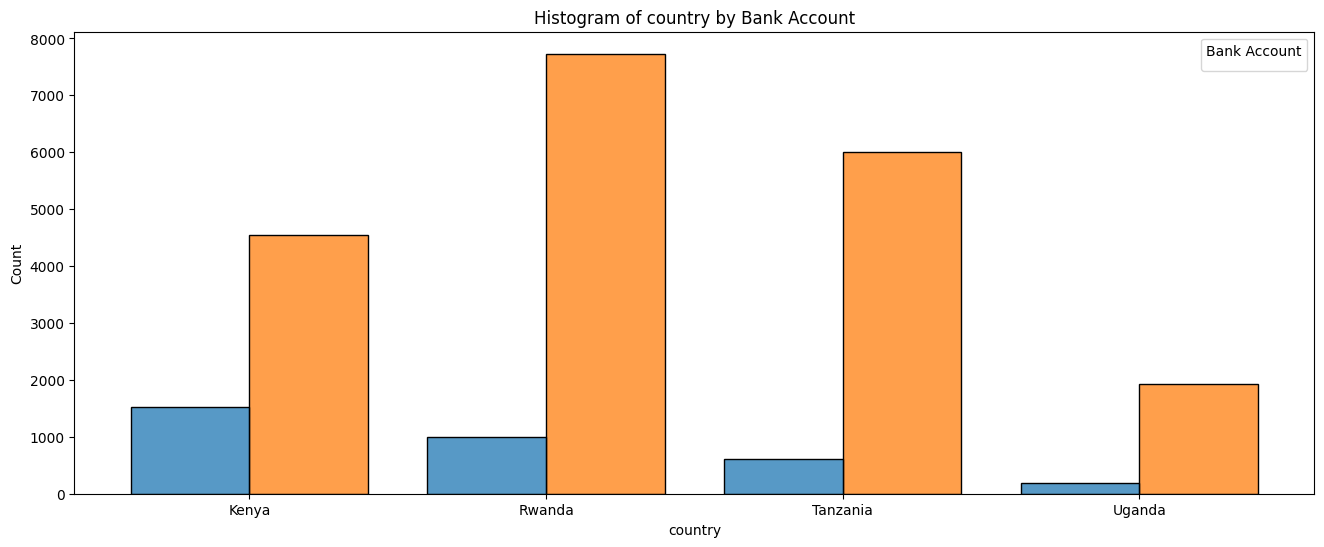

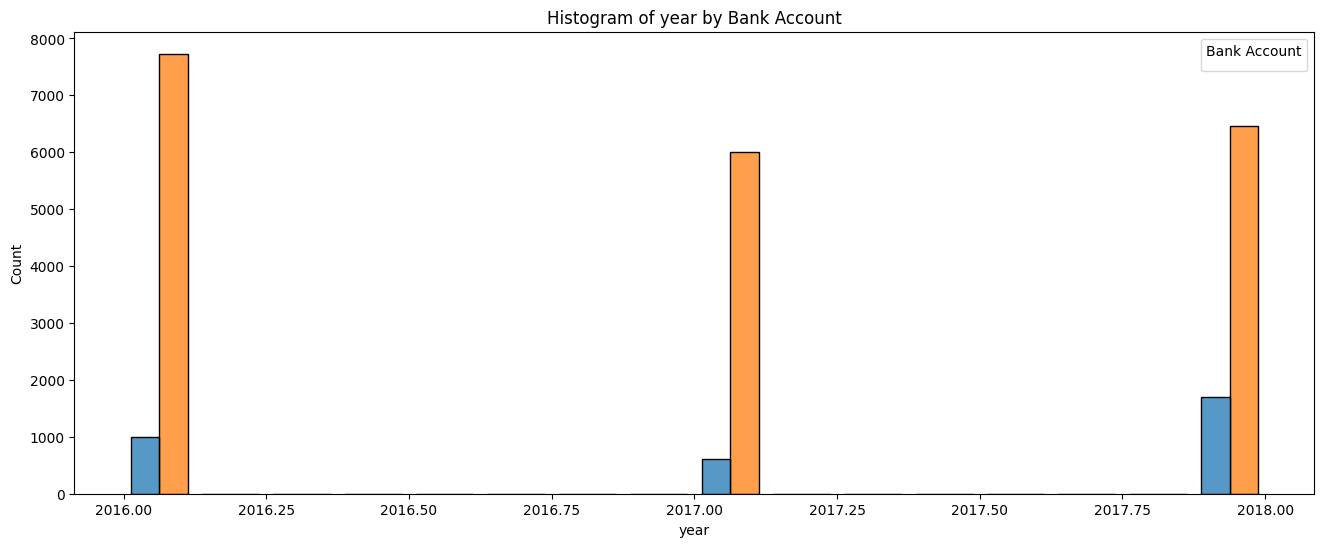

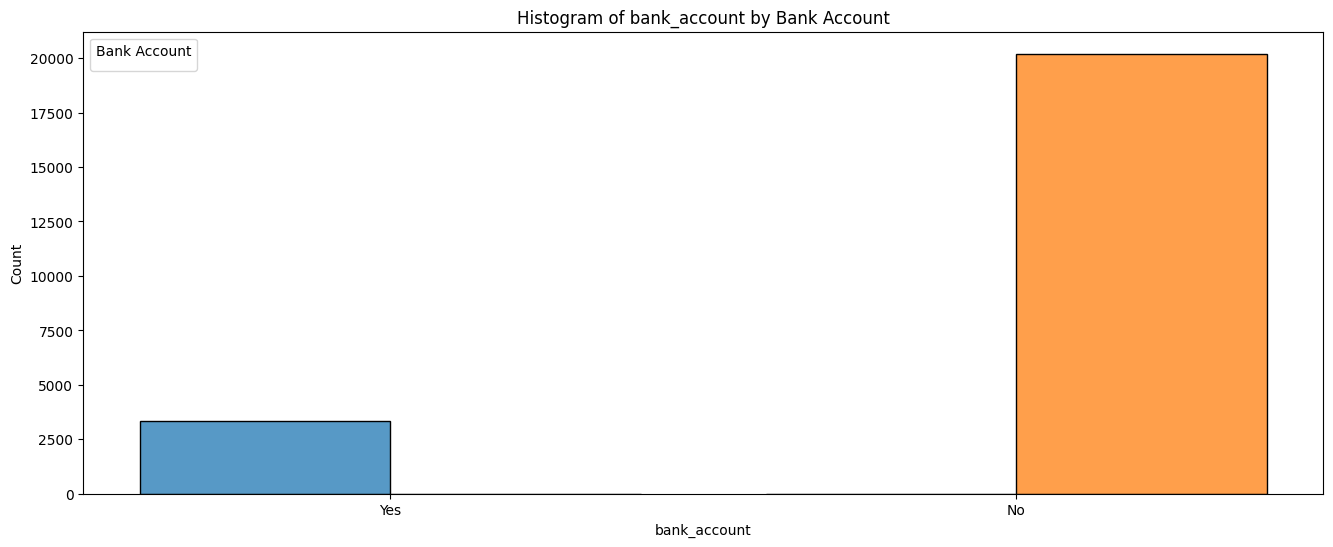

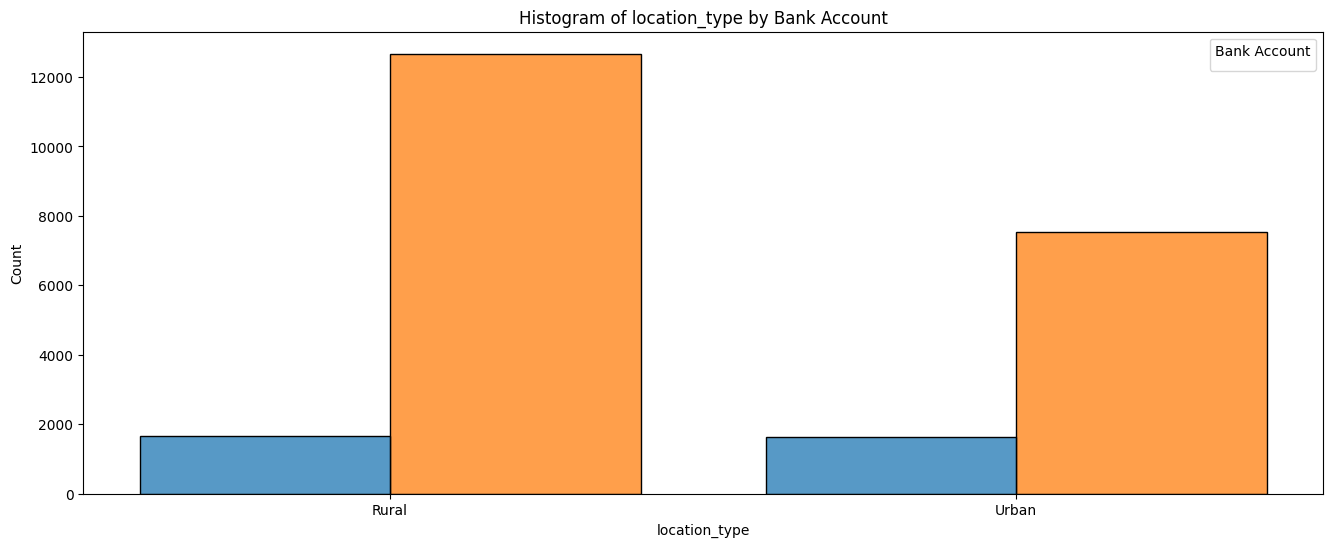

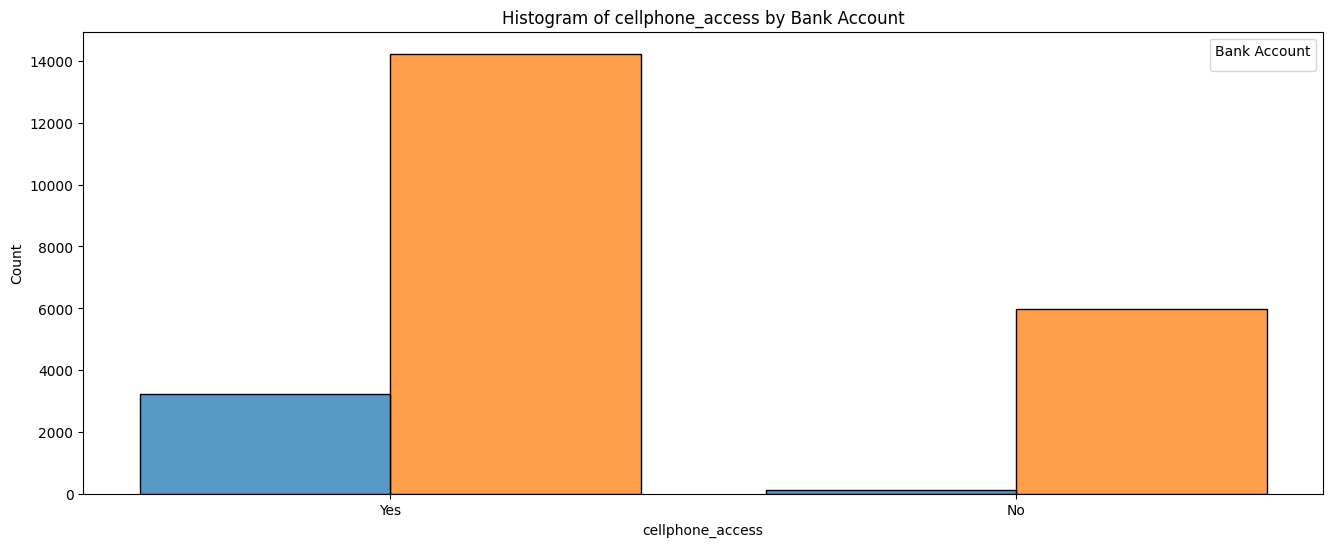

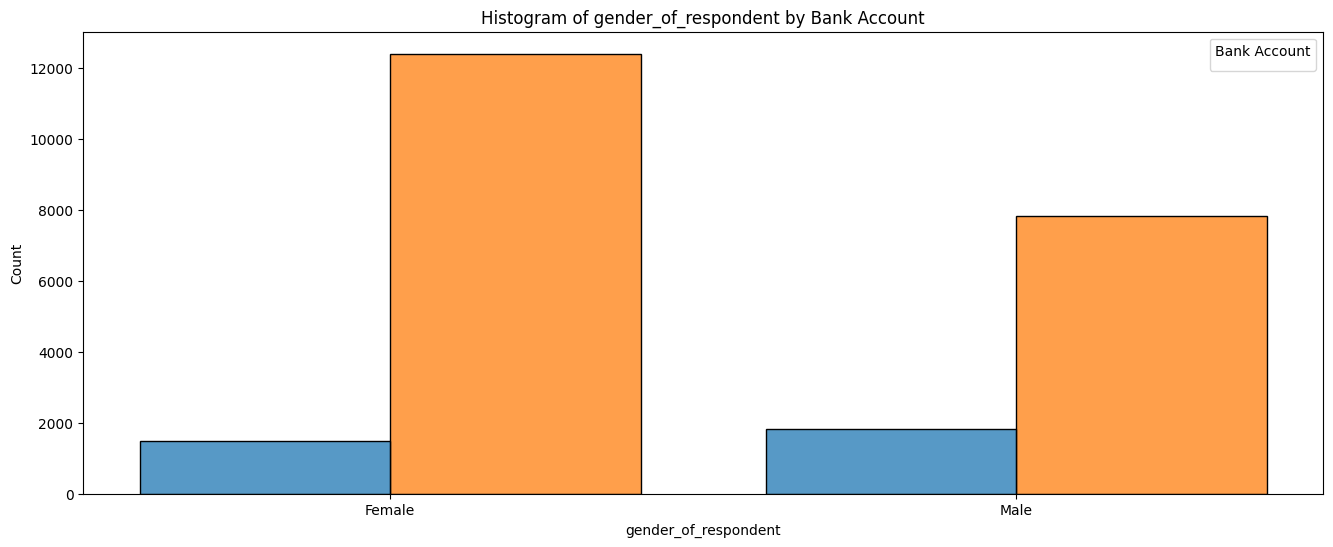

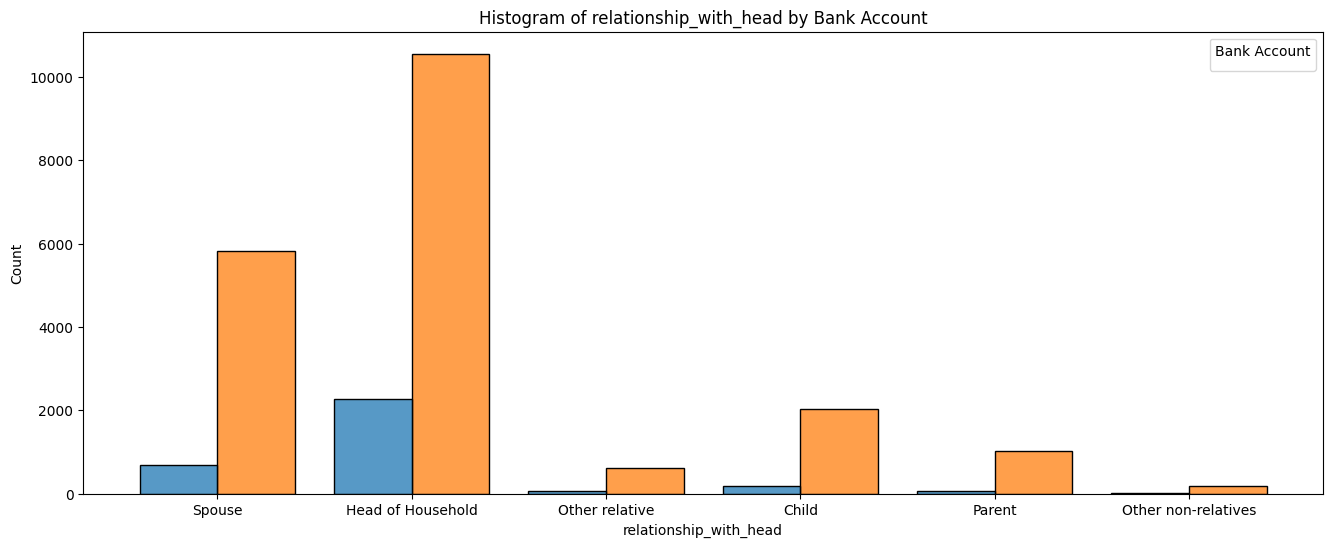

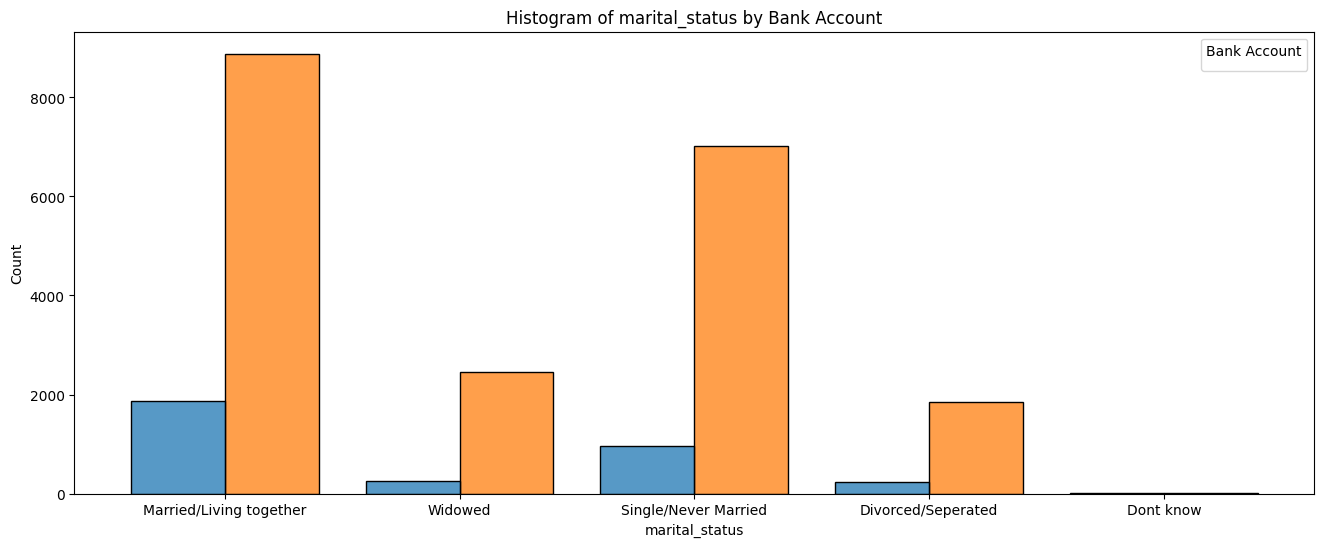

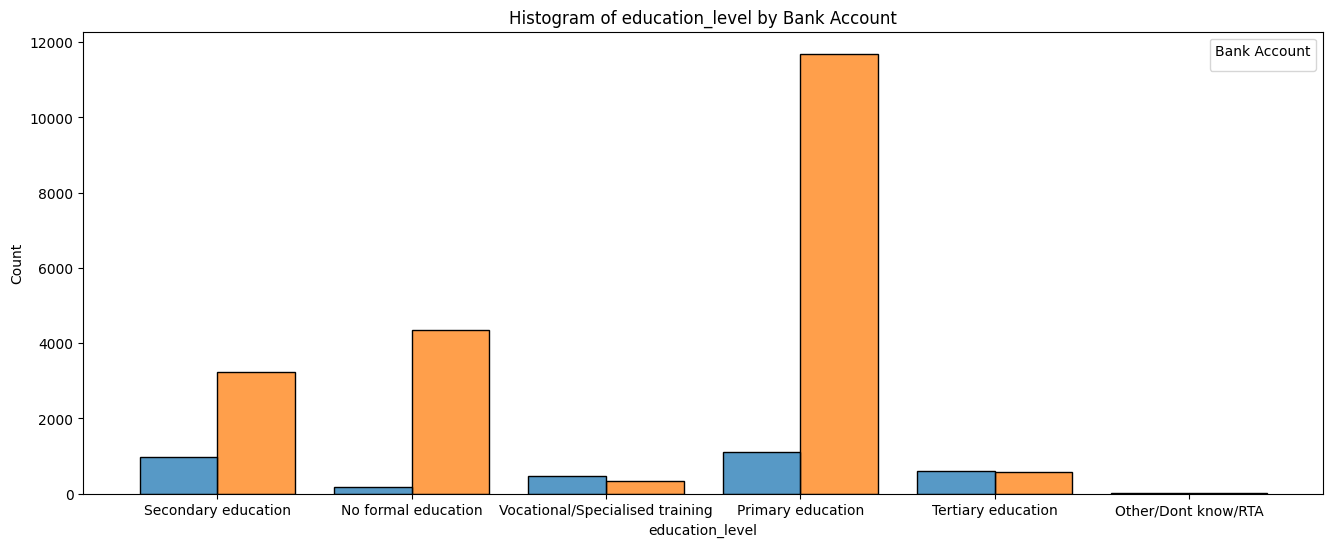

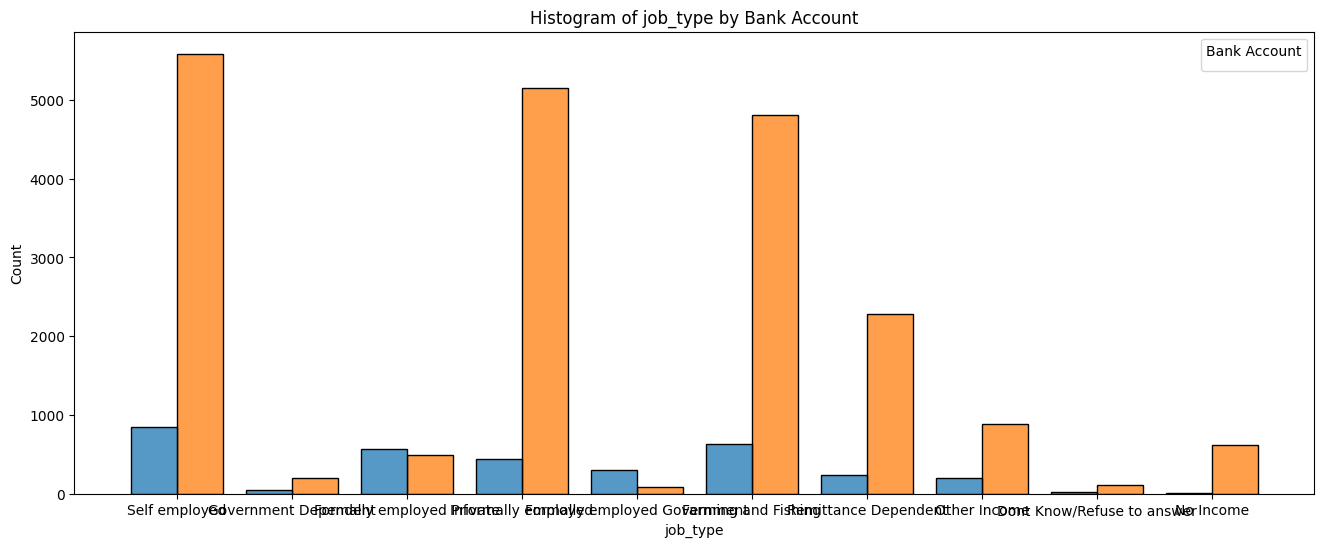

In [36]:
# plot low cardinality features
for feature in low_cardinality_features:
    plt.figure(figsize=(16, 6))
    sns.histplot(data=train, x=feature, hue='bank_account', multiple='dodge', shrink=0.8)
    plt.title(f"Histogram of {feature} by Bank Account")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title='Bank Account')
    plt.show()

In [28]:
# countries the surveys from
countries = train['country'].unique()
countries

array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object)

In [45]:
for country in countries:
    df = train[train['country'] == country]
    for feature in low_cardinality_features:  # Adjust for correct feature list
        fig = px.histogram(df,
                     x=feature,
                     color='bank_account',
                     title=f"Histogram of {feature} by Bank Account {country.upper()}"
            )
        fig.update_layout(barmode='group')

        fig.show()

In [42]:
for country in countries:
    df = train[train['country'] == country]
    print(f"Country: {country}")
    print(df["bank_account"].value_counts())

Country: Kenya
bank_account
No     4547
Yes    1521
Name: count, dtype: int64
Country: Rwanda
bank_account
No     7732
Yes    1003
Name: count, dtype: int64
Country: Tanzania
bank_account
No     6013
Yes     607
Name: count, dtype: int64
Country: Uganda
bank_account
No     1920
Yes     181
Name: count, dtype: int64


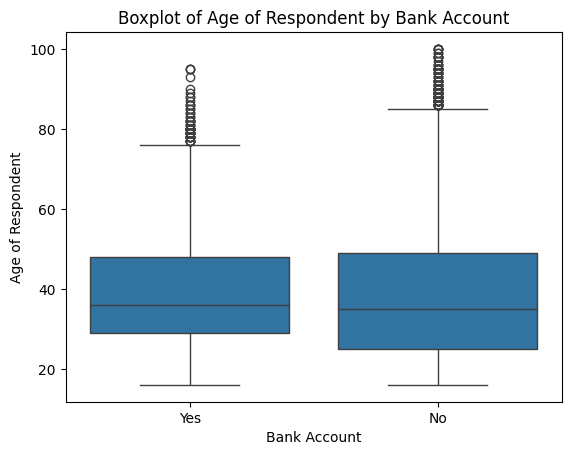

In [48]:
sns.boxplot(data=train, x='bank_account', y='age_of_respondent')
plt.title("Boxplot of Age of Respondent by Bank Account")
plt.xlabel("Bank Account")
plt.ylabel("Age of Respondent")
plt.show()

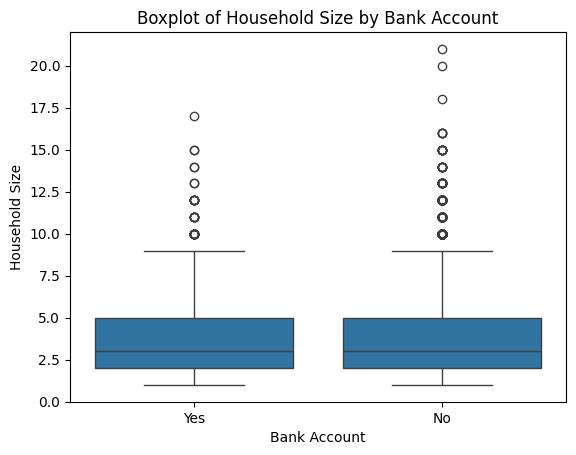

In [50]:
sns.boxplot(data=train, x='bank_account', y='household_size')
plt.title("Boxplot of Household Size by Bank Account")
plt.xlabel("Bank Account")
plt.ylabel("Household Size")
plt.show()

In [52]:
fig = px.box(train, x="bank_account", y="household_size", color="country")
fig.update_layout(title="Boxplot of Household Size by Bank Account and Country")

fig.show()

In [53]:
fig = px.box(train, x="bank_account", y="age_of_respondent", color="country")
fig.update_layout(title="Boxplot of Age of Respondent by Bank Account and Country")

fig.show()

In [60]:
for col in train.columns:
    print(col)
    print(train[col].value_counts())

country
country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: count, dtype: int64
year
year
2016    8735
2018    8169
2017    6620
Name: count, dtype: int64
uniqueid
uniqueid
uniqueid_1       4
uniqueid_1413    4
uniqueid_1411    4
uniqueid_1410    4
uniqueid_1409    4
                ..
uniqueid_7318    1
uniqueid_7317    1
uniqueid_7316    1
uniqueid_7315    1
uniqueid_8759    1
Name: count, Length: 8735, dtype: int64
bank_account
bank_account
No     20212
Yes     3312
Name: count, dtype: int64
location_type
location_type
Rural    14343
Urban     9181
Name: count, dtype: int64
cellphone_access
cellphone_access
Yes    17454
No      6070
Name: count, dtype: int64
household_size
household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: count, dtype: int64
age_of_respondent
age_of

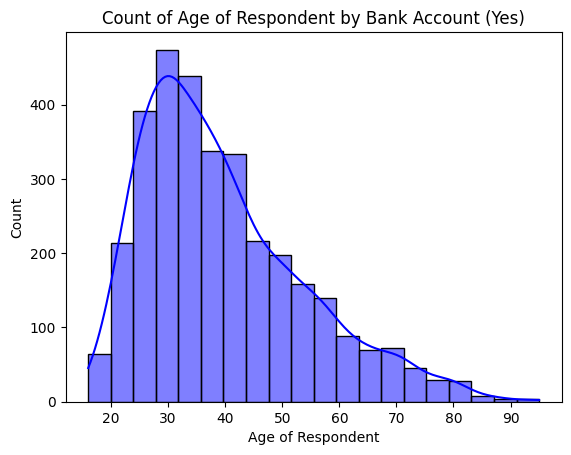

In [77]:

sns.histplot(
    data=train[train["bank_account"] == "Yes"],
    x="age_of_respondent",
    bins=20,
    kde=True,
    color="blue"
)
plt.title("Count of Age of Respondent by Bank Account (Yes)")
plt.xlabel("Age of Respondent")
plt.ylabel("Count")
plt.show()


In [74]:
# age value to categorical value with range

def age_to_category(age):
    if age <= 22:
        return "15-25"
    elif age <= 36:
        return "22-36"
    elif age <= 47:
        return "37-47"
    elif age <= 60:
        return "48-60"
    else:
        return "60+"

In [75]:
train["age_category"] = train["age_of_respondent"].apply(age_to_category)

In [76]:
train["age_category"].value_counts()

age_category
22-36    8975
37-47    4565
15-25    3659
48-60    3487
60+      2838
Name: count, dtype: int64

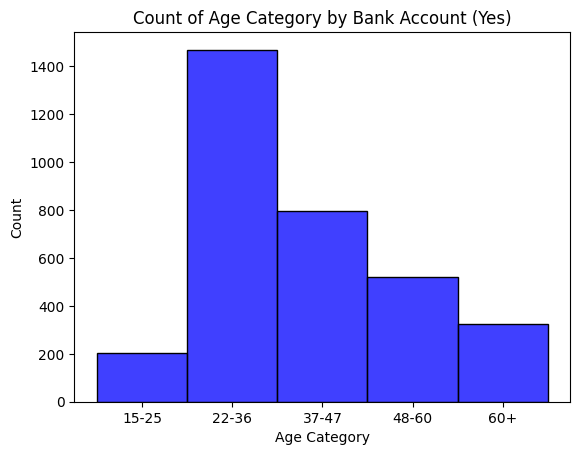

In [86]:
train["age_category"] = pd.Categorical(
    train["age_category"], categories=["15-25", "22-36", "37-47", "48-60", "60+"], ordered=True
)

sns.histplot(
    data=train[train["bank_account"] == "Yes"],
    x="age_category",
    color="blue",

)
plt.title("Count of Age Category by Bank Account (Yes)")
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.show()

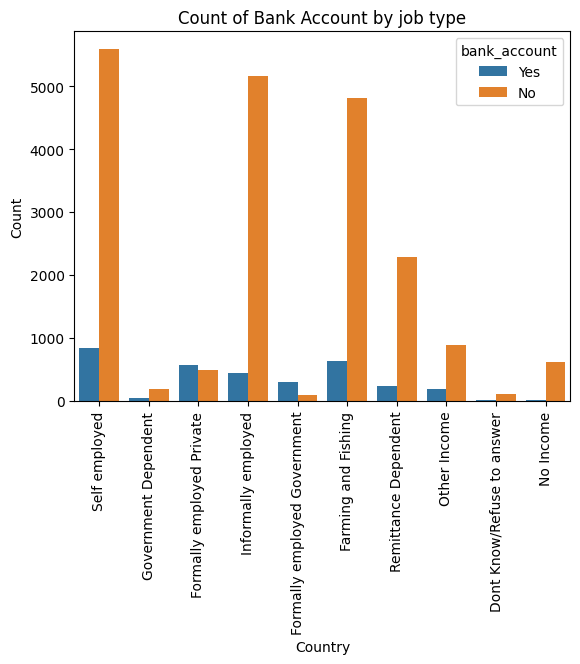

In [106]:
dropped_features = ["uniqueid",  "year", "age_of_respondent"]

sns.countplot(data=train, x="job_type", hue="bank_account")
plt.title("Count of Bank Account by job type")
plt.xlabel("Country")

plt.xticks(rotation=90)

plt.ylabel("Count")
plt.show()

In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 23524 non-null  object  
 1   year                    23524 non-null  int64   
 2   uniqueid                23524 non-null  object  
 3   bank_account            23524 non-null  object  
 4   location_type           23524 non-null  object  
 5   cellphone_access        23524 non-null  object  
 6   household_size          23524 non-null  int64   
 7   age_of_respondent       23524 non-null  int64   
 8   gender_of_respondent    23524 non-null  object  
 9   relationship_with_head  23524 non-null  object  
 10  marital_status          23524 non-null  object  
 11  education_level         23524 non-null  object  
 12  job_type                23524 non-null  object  
 13  age_category            23524 non-null  category
dtypes: category(1), int64(

In [ ]:
train.drop(dropped_features, axis=1, inplace=True)

In [109]:
for col in train.columns:
    print(train[col].value_counts())

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: count, dtype: int64
bank_account
No     20212
Yes     3312
Name: count, dtype: int64
location_type
Rural    14343
Urban     9181
Name: count, dtype: int64
cellphone_access
Yes    17454
No      6070
Name: count, dtype: int64
household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: count, dtype: int64
gender_of_respondent
Female    13877
Male       9647
Name: count, dtype: int64
relationship_with_head
Head of Household      12831
Spouse                  6520
Child                   2229
Parent                  1086
Other relative           668
Other non-relatives      190
Name: count, dtype: int64
marital_status
Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperate

In [110]:
for col in train.select_dtypes("object"):
    print(col)
    print(train[col].nunique())

country
4
bank_account
2
location_type
2
cellphone_access
2
gender_of_respondent
2
relationship_with_head
6
marital_status
5
education_level
6
job_type
10


In [111]:
# object type features to categorical features
for col in train.select_dtypes("object"):
    train[col] = pd.Categorical(train[col])

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 23524 non-null  category
 1   bank_account            23524 non-null  category
 2   location_type           23524 non-null  category
 3   cellphone_access        23524 non-null  category
 4   household_size          23524 non-null  int64   
 5   gender_of_respondent    23524 non-null  category
 6   relationship_with_head  23524 non-null  category
 7   marital_status          23524 non-null  category
 8   education_level         23524 non-null  category
 9   job_type                23524 non-null  category
 10  age_category            23524 non-null  category
dtypes: category(10), int64(1)
memory usage: 415.5 KB


In [113]:
# categorical features encoding by Ordinal encoding
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

for col in train.select_dtypes("category"):
    train[col] = encoder.fit_transform(train[[col]])


In [114]:
train.head()

country  bank_account  location_type  cellphone_access  household_size  \
0      0.0           1.0            0.0               1.0               3   
1      0.0           0.0            0.0               0.0               5   
2      0.0           1.0            1.0               1.0               5   
3      0.0           0.0            0.0               1.0               5   
4      0.0           0.0            1.0               0.0               8   

   gender_of_respondent  relationship_with_head  marital_status  \
0                   0.0                     5.0             2.0   
1                   0.0                     1.0             4.0   
2                   1.0                     3.0             3.0   
3                   0.0                     1.0             2.0   
4                   1.0                     0.0             3.0   

   education_level  job_type  age_category  
0              3.0       9.0           1.0  
1              0.0       4.0           4.0  
2              5.0       9.0           1.0  
3              2.0       3.0           1.0  
4              2.0       5.0           1.0

# Data Splitting

In [117]:
# data splitting to test and train and feature matrix and target vector
from sklearn.model_selection import train_test_split

X = train.drop("bank_account", axis=1)
y = train["bank_account"]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18819, 10), (4705, 10), (18819,), (4705,))

In [120]:
under_sample = RandomUnderSampler(random_state=42)
over_sample = RandomOverSampler(random_state=42)


X_train_under, y_train_under = under_sample.fit_resample(X_train, y_train)
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train)

# Model Building

## baseline

In [125]:
# baseline
acc_baseline = y_train.value_counts(normalize=True).max()
acc_baseline

0.858122110632871

# model building

In [126]:
# binary classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# model evalution

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(),
    XGBClassifier(),
    LGBMClassifier()
]

Model: LogisticRegression
Normal_dataset Accuracy: 0.8793
Under_sampling Accuracy: 0.7371
Over_sampling Accuracy: 0.7360
###################################################
Model: DecisionTreeClassifier
Normal_dataset Accuracy: 0.8629
Under_sampling Accuracy: 0.7575
Over_sampling Accuracy: 0.8006
###################################################
Model: RandomForestClassifier
Normal_dataset Accuracy: 0.8750
Under_sampling Accuracy: 0.7683
Over_sampling Accuracy: 0.8121
###################################################
Model: SVC
Normal_dataset Accuracy: 0.8803
Under_sampling Accuracy: 0.7719
Over_sampling Accuracy: 0.7828
###################################################
Model: KNeighborsClassifier
Normal_dataset Accuracy: 0.8772
Under_sampling Accuracy: 0.8043
Over_sampling Accuracy: 0.8363
###################################################
Model: GaussianNB
Normal_dataset Accuracy: 0.8470
Under_sampling Accuracy: 0.5596
Over_sampling Accuracy: 0.5696
###########################

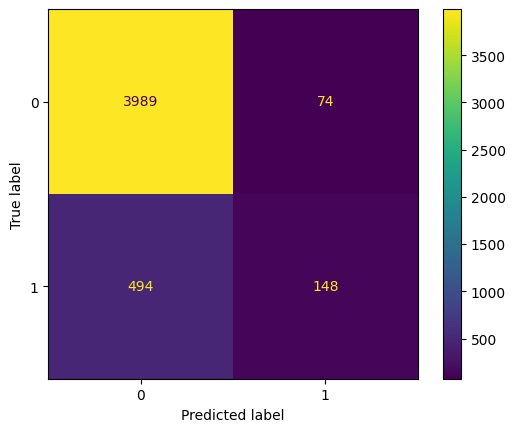

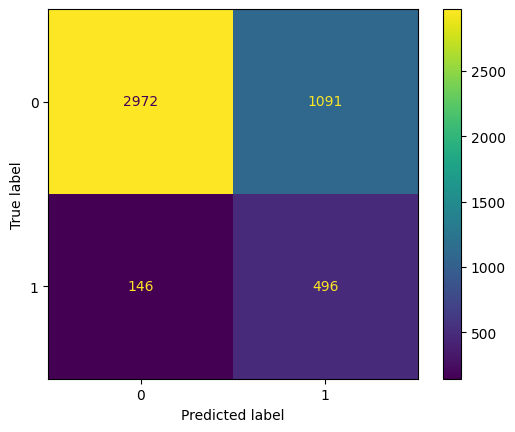

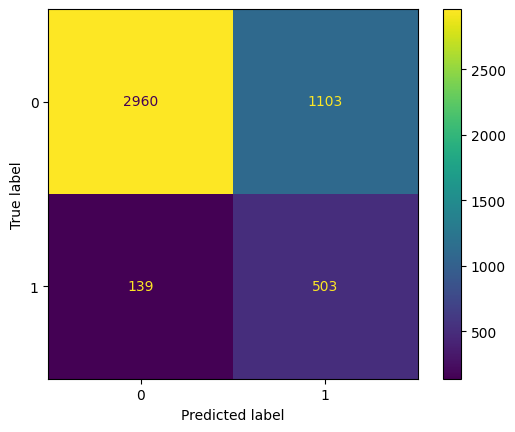

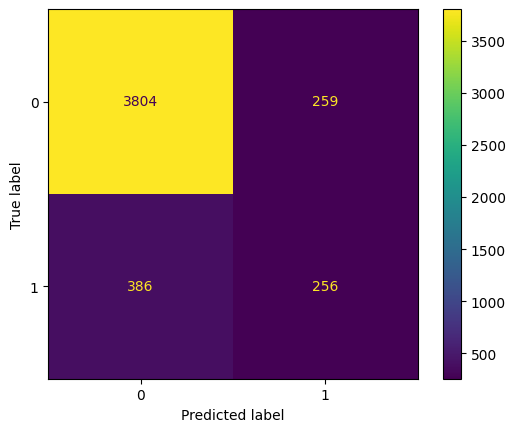

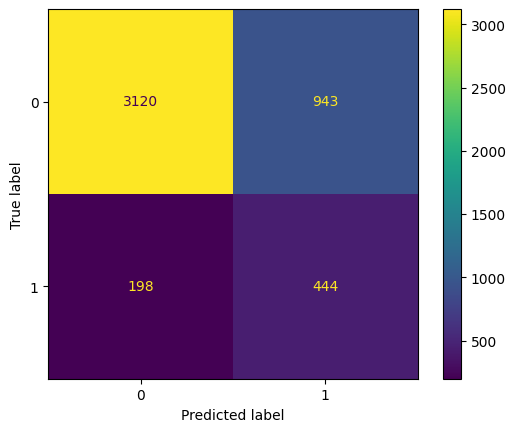

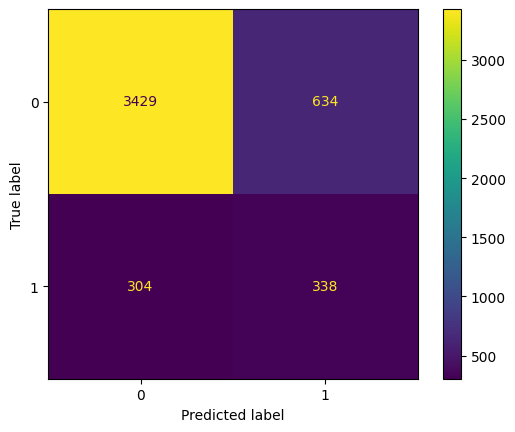

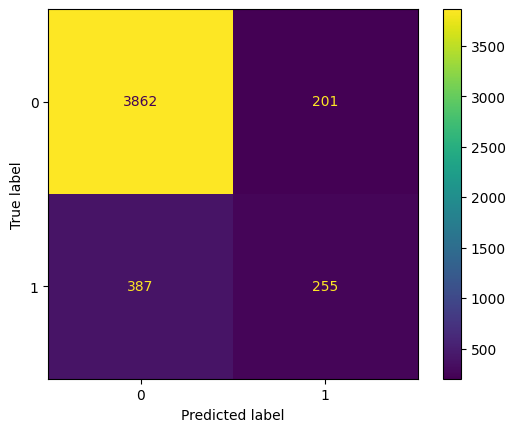

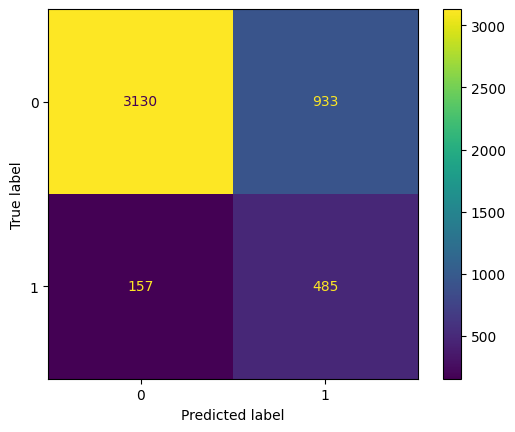

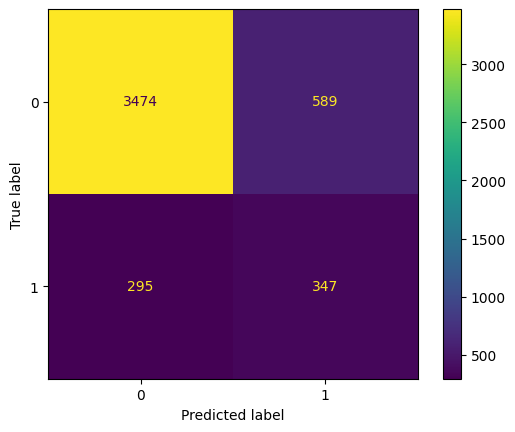

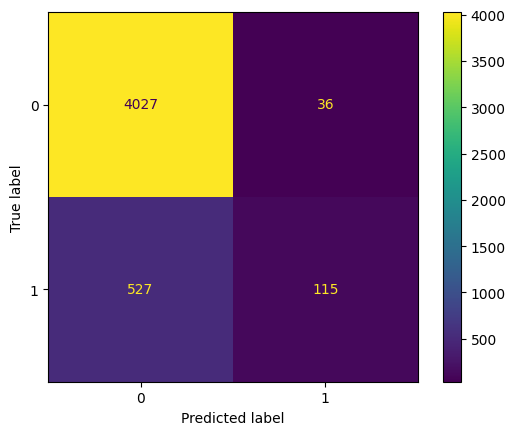

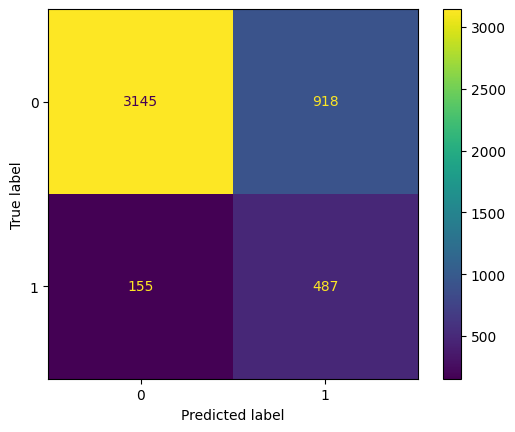

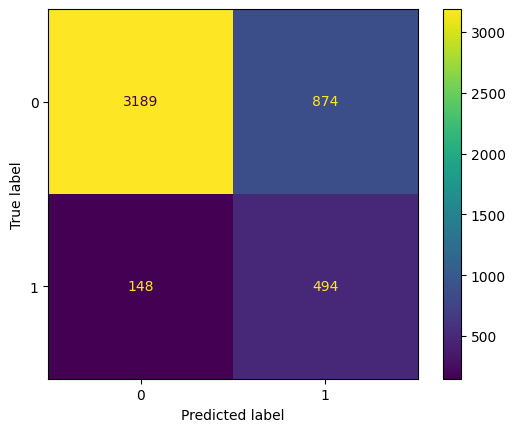

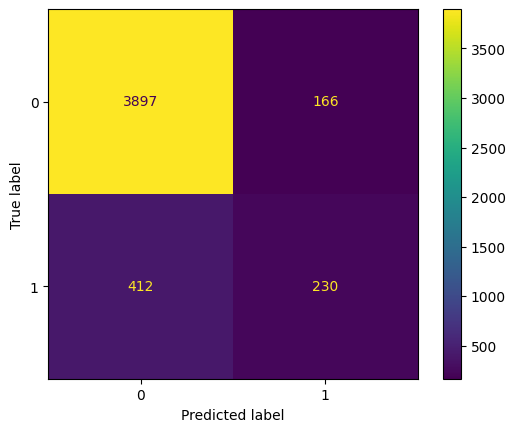

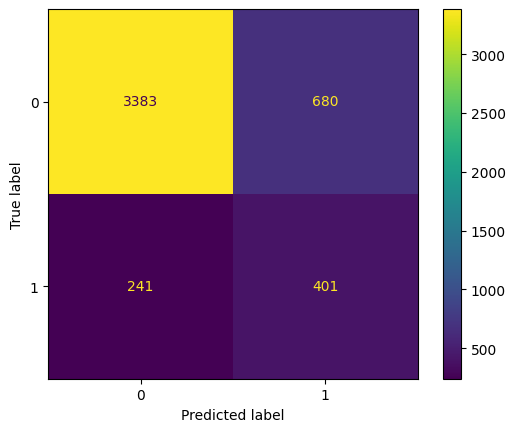

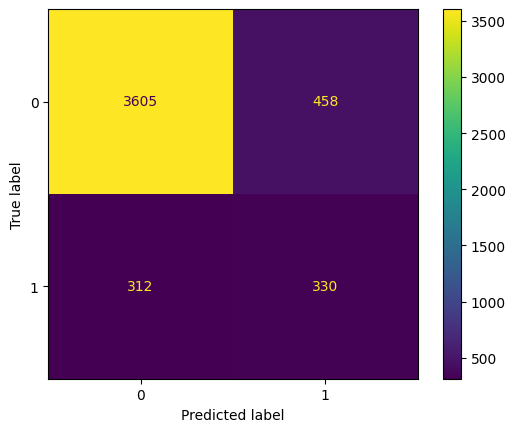

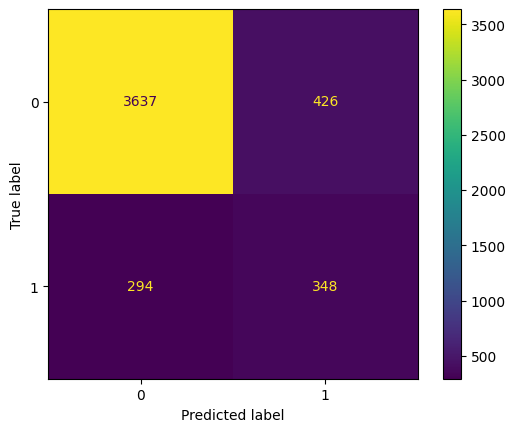

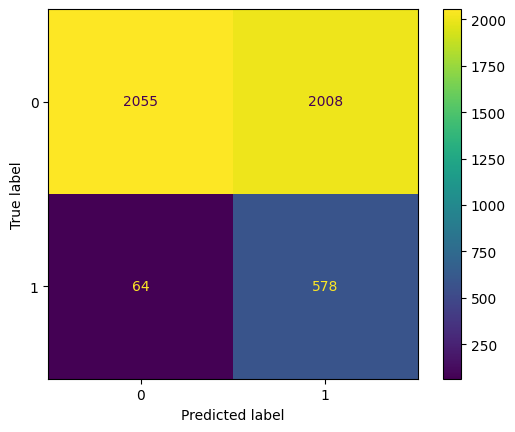

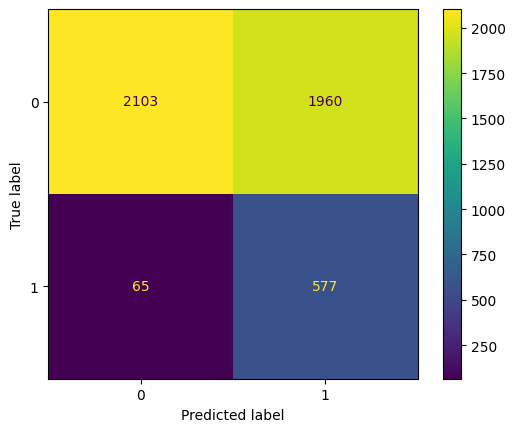

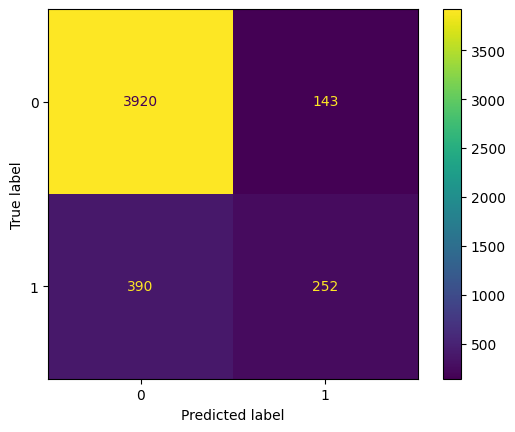

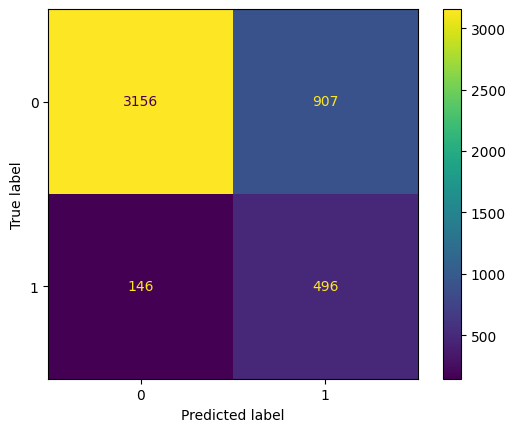

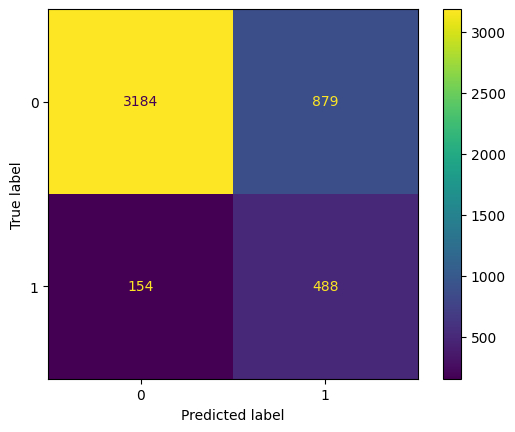

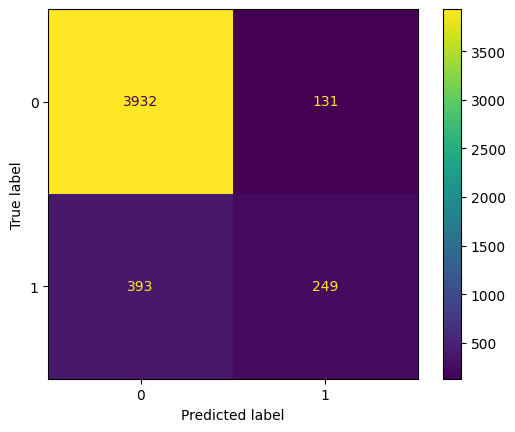

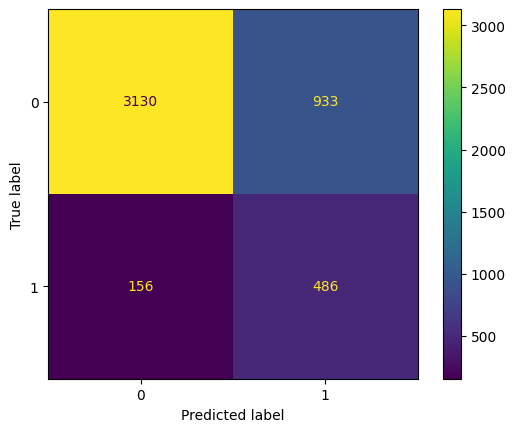

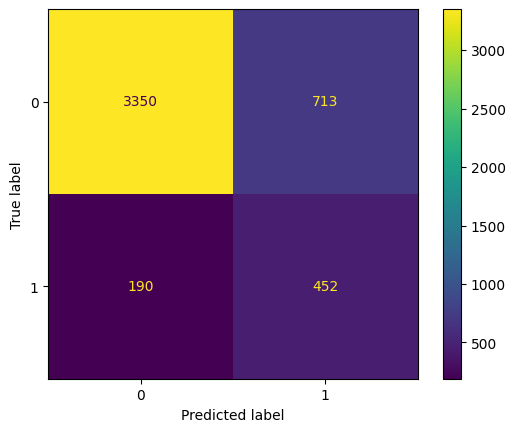

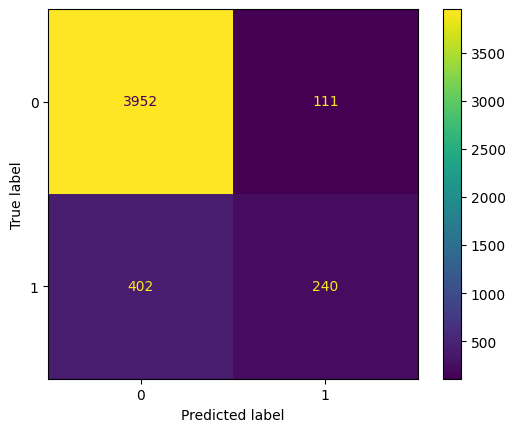

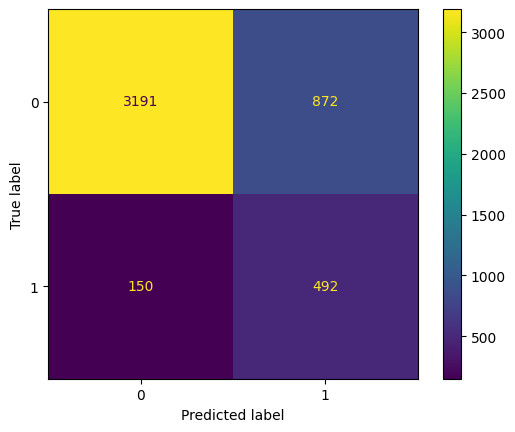

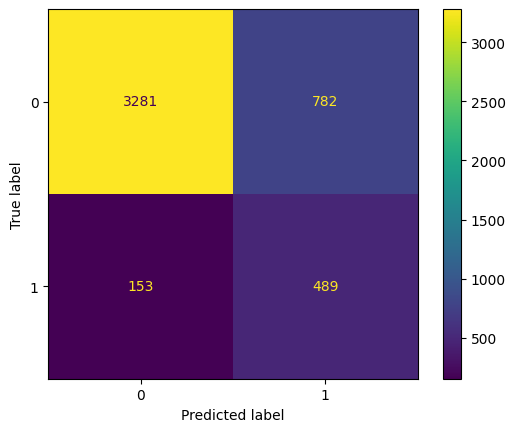

In [135]:
# choose the best model
model_over_data = {
    "Normal_dataset": (X_train, y_train),
    "Under_sampling": (X_train_under, y_train_under),
    "Over_sampling": (X_train_over, y_train_over)
}

best_model = None
best_accuracy = 0.0
best_data = None

for model in models:
    model_name = model.__class__.__name__
    print(f"Model: {model_name}")
    for data_name, (X_train_data, y_train_data) in model_over_data.items():
        model.fit(X_train_data, y_train_data)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
        print(f"{data_name} Accuracy: {acc:.4f}")
        # print(f"{data_name} Accuracy: {acc:.4f}")
        # print(f"{data_name} Precision: {prec:.4f}")
        # print(f"{data_name} Recall: {rec:.4f}")
        # print(f"{data_name} F1 Score: {f1:.4f}")
        # print("==============================")
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model_name
            best_data = data_name
    print("###################################################")


print(f"Best Model: {best_model}")
print(f"Best Data: {best_data}")
print(f"Best Accuracy: {best_accuracy:.4f}")

### **Model Evalution**

In [140]:
best_model = LGBMClassifier(force_col_wise=True)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

[LightGBM] [Info] Number of positive: 2670, number of negative: 16149
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 18819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141878 -> initscore=-1.799780
[LightGBM] [Info] Start training from score -1.799780


In [144]:
confusion_matrix(y_test, y_pred)

array([[3952,  111],
       [ 402,  240]])

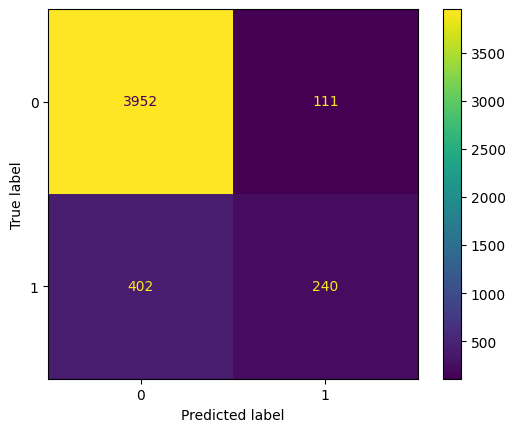

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


In [143]:
best_model.feature_importances_

array([370, 186, 103, 522, 149, 200, 228, 339, 557, 346], dtype=int32)

In [145]:
# Gradient boosting tree model library
from sklearn.ensemble import GradientBoostingClassifier


gbt_model = GradientBoostingClassifier()
gbt_model.fit(X_train, y_train)
y_pred = gbt_model.predict(X_test)



In [147]:
# score
acc = accuracy_score(y_test, y_pred)
acc

0.8903294367693942

In [148]:
# cv result
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(gbt_model, X_train, y_train, cv=5)
cv_scores

array([0.88868225, 0.88496281, 0.89213603, 0.87832094, 0.88891842])

In [151]:
# hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': range(5, 100, 5),
    'max_depth': range(3, 10, 2),
}

grid_search = GridSearchCV(
    gbt_model, param_grid, cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 76 candidates, totalling 380 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'n_estimators': range(5, 100, 5)},
             scoring='accuracy', verbose=1)

In [152]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 75}

In [154]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      4063
         1.0       0.71      0.34      0.46       642

    accuracy                           0.89      4705
   macro avg       0.80      0.66      0.70      4705
weighted avg       0.88      0.89      0.87      4705



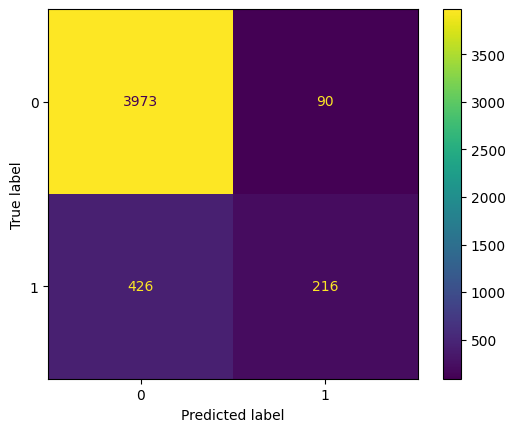

In [155]:
c = confusion_matrix(y_test, grid_search.predict(X_test))
ConfusionMatrixDisplay(c).plot()

In [156]:
acc = accuracy_score(y_test, grid_search.predict(X_test))
acc

0.8903294367693942

In [158]:
def make_cnf_matrix():
    y_pred = grid_search.predict(X_test)
    c = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = c.ravel()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    return tn, fp, fn, tp

(3973, 90, 426, 216)

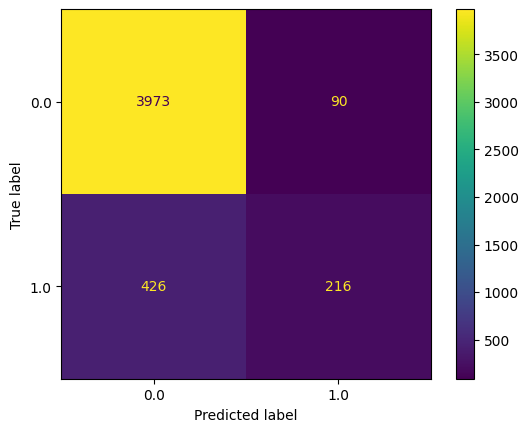

In [159]:
make_cnf_matrix()

In [182]:
def data_preprocessor(path):
    df = pd.read_csv(FILE_PATH + path)
    df["ID"] = df["uniqueid"] +" x "+ df["country"]
    df.set_index("ID", inplace=True)
    dropped_features = ["year", "age_of_respondent", "uniqueid"]

    df["age_category"] = df["age_of_respondent"].apply(age_to_category)
    df.drop(dropped_features, axis=1, inplace=True)
    for col in df.select_dtypes("object"):
        df[col] = pd.Categorical(df[col])
    encoder = OrdinalEncoder()
    for col in df.select_dtypes("category"):
        df[col] = encoder.fit_transform(df[[col]])

    return df


In [183]:
test = data_preprocessor(TEST_PATH)

In [184]:
for col in test.columns:
    if col not in X.columns:
        print(col)

In [185]:
ss = pd.read_csv(FILE_PATH + SAMPLE_SUBMISSION_PATH)
ss.head()

unique_id  bank_account
0  uniqueid_1 x Kenya             0
1  uniqueid_2 x Kenya             0
2  uniqueid_3 x Kenya             0
3  uniqueid_4 x Kenya             0
4  uniqueid_5 x Kenya             0

In [186]:
# create predict and save to dataframe test dataset
test_pred = grid_search.predict(test)

submission = pd.DataFrame({"uniqueid": test.index, "bank_account": test_pred})

from datetime import datetime

# Get the current date and time
now = datetime.now()

# Format the date and time as a string
date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S")
# save file
submission.to_csv(FILE_PATH + f"submission_Financial_inclusion_{date_time_str}.csv", index=False)

In [187]:
submission.head()

uniqueid  bank_account
0  uniqueid_6056 x Kenya           1.0
1  uniqueid_6060 x Kenya           1.0
2  uniqueid_6065 x Kenya           0.0
3  uniqueid_6072 x Kenya           0.0
4  uniqueid_6073 x Kenya           0.0

0.8903294367693942